In [77]:
import torch
import pyro
import matplotlib.pyplot as plt
import pyro.distributions as dist
from torch.distributions import constraints

In [87]:
import matplotlib.pyplot as plt
import numpy as np
import pyro
import pyro.distributions as dist
import torch

from matplotlib.patches import Ellipse
from pyro import poutine
from pyro.contrib.autoguide import AutoDelta
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate
from torch.distributions import constraints

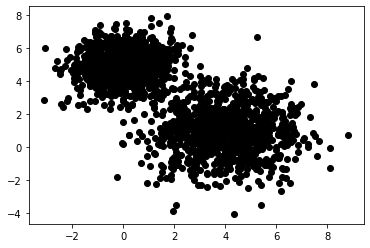

In [65]:
# mu1 = torch.tensor([0.,5.])
# sigma1 = torch.tensor([[1.,0.],[0.,1.]])

# mu2 = torch.tensor([4.,1.])
# sigma2 = torch.tensor([[2.,0.],[0.,2.]])

# #dist 1
# X1 = dist.MultivariateNormal(mu1,sigma1)
# X2 = dist.MultivariateNormal(mu2, sigma2)

# len_samples = 1000
# samples1 = [pyro.sample("samples1",X1) for _ in range(len_samples)]
# samples2 = [pyro.sample("samples2",X2) for _ in range(len_samples)]


# data = torch.cat((torch.stack(samples1),torch.stack(samples2)))

# # m.sample([10,1])
# #s = X.sample([10])
# # plt.scatter(s[:,0],'r')
# # plt.scatter(s[:,0],s[:,1],'b')
# x=data[:,0]
# y = data[:,1]

# # print(x)
# # print(y)

# plt.scatter(x,y,c='black')

In [101]:
def model(data):
    w = torch.FloatTensor([0.5])
    scales = torch.FloatTensor([[[1., 0.], [0., 2.]], [[3., 0.], [0., 4.]]])
    mu = torch.FloatTensor([[1., 2.], [3., 4.]])

    weights = pyro.param('weights',w,constraint=constraints.unit_interval)
    scales = pyro.param('scales',scales,constraint=constraints.positive)
    locs = pyro.param('locs',mu)
    
    with pyro.iarange('data',data.size(0)):
        assignment = pyro.sample('assignment',dist.Bernoulli(torch.ones(len(data))*weights)).to(torch.int64)
        pyro.sample('obs',dist.MultivariateNormal(locs[assignment],scales[assignment]))

def full_guide(data):
    with pyro.iarange('data',data.size(0)):
        assignment_probs = pyro.param('assignment_probs', torch.ones(len(data)) / K,
                                      constraint=constraints.unit_interval)
        pyro.sample('assignment', dist.Bernoulli(assignment_probs), infer={"enumerate": "sequential"})
    
                                 
def initialize(data):
    pyro.clear_param_store()

    optim = pyro.optim.Adam({'lr': 0.1, 'betas': [0.8, 0.99]})
    elbo = TraceEnum_ELBO(max_iarange_nesting=1)
    svi = SVI(model, full_guide, optim, loss=elbo)

    # Initialize weights to uniform.
    pyro.param('auto_weights', 0.5 * torch.ones(K), constraint=constraints.simplex)

    # Assume half of the data variance is due to intra-component noise.
    var = (data.var() / 2).sqrt()
    pyro.param('auto_scale', torch.tensor([var]*4), constraint=constraints.positive)

    # Initialize means from a subsample of data.
    pyro.param('auto_locs', data[torch.multinomial(torch.ones(len(data)) / len(data), K)])

    loss = svi.loss(model, full_guide, data)

    return loss, svi

def get_samples():
    num_samples = 1000

    # 2 clusters
    # note that both covariance matrices are diagonal
    mu1 = torch.tensor([0., 5.])
    sig1 = torch.tensor([[2., 0.], [0., 3.]])

    mu2 = torch.tensor([5., 0.])
    sig2 = torch.tensor([[4., 0.], [0., 1.]])

    # generate samples
    dist1 = dist.MultivariateNormal(mu1, sig1)
    samples1 = [pyro.sample('samples1', dist1) for _ in range(num_samples)]

    dist2 = dist.MultivariateNormal(mu2, sig2)
    samples2 = [pyro.sample('samples2', dist2) for _ in range(num_samples)]

    data = torch.cat((torch.stack(samples1), torch.stack(samples2)))
    return data

def plot(data, mus=None, sigmas=None, colors='black', figname='fig.png'):
    # Create figure
    fig = plt.figure()

    # Plot data
    x = data[:, 0]
    y = data[:, 1]
    plt.scatter(x, y, 24, c=colors)

    # Plot cluster centers
    if mus is not None:
        x = [float(m[0]) for m in mus]
        y = [float(m[1]) for m in mus]
        plt.scatter(x, y, 99, c='red')

    # Plot ellipses for each cluster
    if sigmas is not None:
        for sig_ix in range(K):
            ax = fig.gca()
            cov = np.array(sigmas[sig_ix])
            lam, v = np.linalg.eig(cov)
            lam = np.sqrt(lam)
            ell = Ellipse(xy=(x[sig_ix], y[sig_ix]),
                          width=lam[0]*4, height=lam[1]*4,
                          angle=np.rad2deg(np.arccos(v[0, 0])),
                          color='blue')
            ell.set_facecolor('none')
            ax.add_artist(ell)

    # Save figure
    fig.savefig(figname)
    

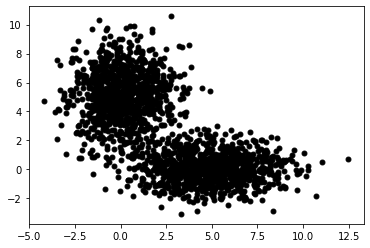

In [102]:
data = get_samples()
plot(data)

locs: tensor([[1., 2.],
        [3., 4.]], requires_grad=True)
scales: tensor([[[0.9048, 0.0000],
         [0.0000, 1.8097]],

        [[2.7145, 0.0000],
         [0.0000, 3.6193]]], grad_fn=<AddBackward0>)
weights = tensor([0.5000], grad_fn=<ClampBackward>)
assignments: tensor([0.4750, 0.4750, 0.4750,  ..., 0.4750, 0.4750, 0.4750],
       grad_fn=<ClampBackward>)
locs: tensor([[1., 2.],
        [3., 4.]], requires_grad=True)
scales: tensor([[[0.0036, 0.0000],
         [0.0000, 0.0071]],

        [[0.0914, 0.0000],
         [0.0000, 0.1218]]], grad_fn=<AddBackward0>)
weights = tensor([0.0550], grad_fn=<ClampBackward>)
assignments: tensor([0.0441, 0.0677, 0.0505,  ..., 0.0510, 0.0540, 0.0484],
       grad_fn=<ClampBackward>)
locs: tensor([[1., 2.],
        [3., 4.]], requires_grad=True)
scales: tensor([[[1.3198e-05, 0.0000e+00],
         [0.0000e+00, 2.6397e-05]],

        [[4.7789e-02, 0.0000e+00],
         [0.0000e+00, 6.3718e-02]]], grad_fn=<AddBackward0>)
weights = tensor([0.0077], 

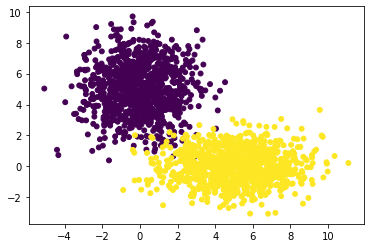

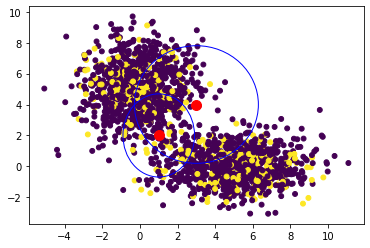

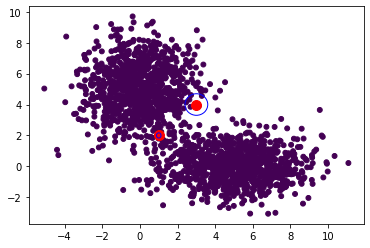

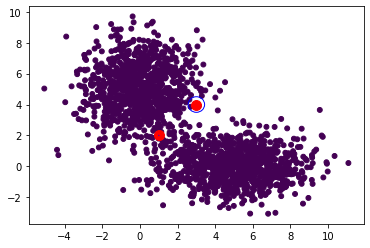

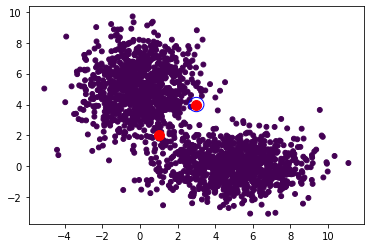

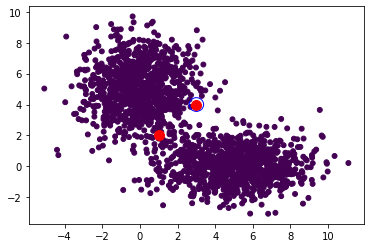

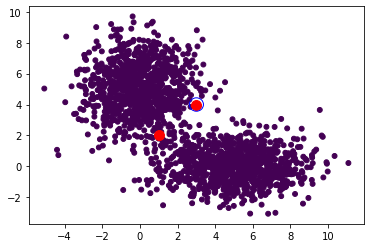

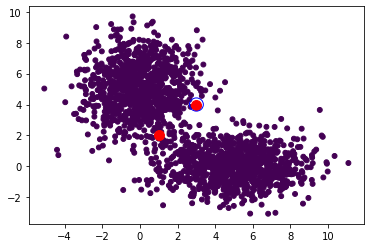

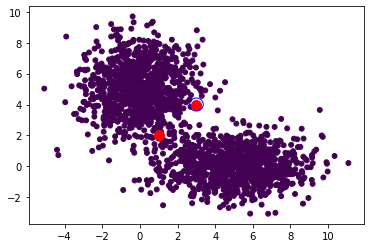

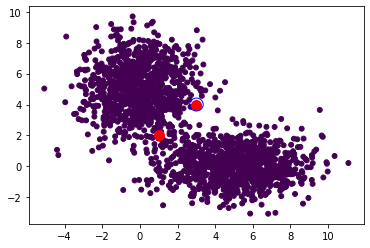

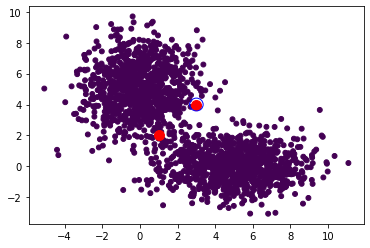

In [104]:
pyro.enable_validation(True)
pyro.set_rng_seed(42)

# Create our model with a fixed number of components
K = 2

data = get_samples()

global_guide = AutoDelta(poutine.block(model, expose=['weights', 'locs', 'scales']))
global_guide = config_enumerate(global_guide, 'parallel')
_, svi = initialize(data)

true_colors = [0] * 1000 + [1] * 1000
plot(data, colors=true_colors, figname='pyro_init.png')

for i in range(500):
    svi.step(data)

    if i % 50 == 0:
        locs = pyro.param('locs')
        scales = pyro.param('scales')
        weights = pyro.param('weights')
        assignment_probs = pyro.param('assignment_probs')

        print("locs: {}".format(locs))
        print("scales: {}".format(scales))
        print('weights = {}'.format(weights))
        print('assignments: {}'.format(assignment_probs))

        # todo plot data and estimates
        assignments = np.uint8(np.round(assignment_probs.data))
        plot(data, locs.data, scales.data, assignments, figname='pyro_iteration{}.png'.format(i))
